In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
from itertools import chain

plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kaon_pn_4GeV_Jul14_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}

hists["hist_pdgid1"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 40, -400, 4000)
                            )
hists["hist_pdgid2"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 40, -400, 4000)
                            )
hists["hist_ke1"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 50, 4, 3500),
                                )
hists["hist_ke2"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 50, 4, 3500),
                                )

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_PNParticle']
    sim_particle_n = ldmx_events['n']['Sim_PNParticle']
    
    masks_id = {#'Kplus': 321,
                #'Kshort': 310,
                'Klong': 130, 
                #'Kminus':-321,
                #'Electron': 11,
                #'Positron': -11,
                'Pion': 211,
                'Pi-': -211,
                'Proton':2212,
                'Neutron':2112,
                'Sigma': 3212,
                'Lambda': 3122,
               }
    masses =   {#'Kplus': 493.677,
                #'Kshort': 493.677,
                'Klong': 493.677,
                #'Kminus': 493.677,
                #'Electron': 0.511,
                #'Positron': 0.511,
                'Pion': 139.57039,
                'Pi-': 139.57039,
                'Proton': 939.565,
                'Neutron': 939.565,
                'Sigma': 1189.36,
                'Lambda': 1115.6,
                }

    kshort_mask = sim_particle.pdgID == 310
    klong_mask  = sim_particle.pdgID == 130
    kplus_mask  = sim_particle.pdgID == 321
    kminus_mask = sim_particle.pdgID == -321
    kaon_mask = kshort_mask | klong_mask | kplus_mask | kminus_mask
    n_kaons = ak.sum(kaon_mask, axis = 1)
    n_kaon_mask = n_kaons == 1
    
    k_anymask = ak.any(klong_mask, axis = 1)
    print(sim_particle[k_anymask & n_kaon_mask].pdgID)
    
    index = ak.argsort(sim_particle.e, axis=-1, ascending=False, stable=True, highlevel=True, behavior=None)
    index = ak.pad_none(index, 2, axis=1)

    padded_pdg = ak.pad_none(sim_particle.pdgID, 2, axis=1)
    pdgID_1 = padded_pdg[index][:,0]
    pdgID_2 = padded_pdg[index][:,1]
    filled_pdg1 = ak.fill_none(pdgID_1, -1000000)
    filled_pdg2 = ak.fill_none(pdgID_2, -1000000)
    
    padded_e = ak.pad_none(sim_particle.e, 2, axis=1)
    e_1 = padded_e[index][:,0]
    e_2 = padded_e[index][:,1]
    filled_e1 = ak.fill_none(e_1, -1000000)
    filled_e2 = ak.fill_none(e_2, -1000000)

    for part,pmask in masks_id.items():
        part_mask1 = (filled_pdg1[k_anymask & n_kaon_mask] == pmask)
        hists["hist_pdgid1"].fill(Ptype= part,
                                     e=flat(filled_pdg1[k_anymask & n_kaon_mask][part_mask1]),
                                     )  
        hists["hist_ke1"].fill(Ptype= part,
                                     e=flat(filled_e1[k_anymask & n_kaon_mask][part_mask1])- masses[part],
                                     ) 
        part_mask2 = (filled_pdg2[k_anymask & n_kaon_mask] == pmask)
        hists["hist_pdgid2"].fill(Ptype= part,
                                     e=flat(filled_pdg2[k_anymask & n_kaon_mask][part_mask2]),
                                     )  
        hists["hist_ke2"].fill(Ptype= part,
                                     e=flat(filled_e2[k_anymask & n_kaon_mask][part_mask2])- masses[part],
                                     )   
    
    #goal: plot for events with 1 Klong and no other kaons

In [6]:
nchunk = 0

for chunk in ldmx_dict:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)


process 1
[[2212, 130, 111, 2112], [2212, -211, 3122, ... 2112], [111, 2212, 211, 130, 2112]]
process 2
[[2212, 3122, 130, 111, 2112], [2212, 130, ... [2212, 130, 211, 3212, -211, 2112]]
process 3
[[-211, 130, 2112], [2212, 130, 3122, ... [2212, 211, 3212, -211, 130, 111, 2112]]
process 4
[[111, 2212, 3122, 130, 2112], [2212, -211, ... [130, 2212, 2112], [3222, 130, 2112]]
process 5
[[3212, 130, 2112], [2212, -211, 211, 130, ... 2112], [2212, 130, 211, 111, 2112]]
process 6
[[2212, 111, -211, 130, 211, 2112], [130, ... [3222, 130, 2112], [130, 2112]]
process 7
[[111, 3212, 130, 2212, 2112], [3122, 130, ... 3222, 130, 2112], [-211, 130, 2112]]
process 8
[[130, 2212, -211, 3212, 111, 2112], [130, ... 111, 2112], [3122, 111, 130, 2212]]
process 9
[[2212, 3122, -211, 211, 130, 111, 2112], ... 3122, 211, 2112], [3122, 130, 2112]]
process 10
[[2212, -211, 111, 130, 2112], [2212, 3212, ... [130, 2112], [2212, 130, 2112]]
process 11
[[2212, 3112, 130, 2112], [2212, 3212, 130, ... 2112], [130, 

[[130, 2212, 111, 2112], [2212, 130, 2112, ... 3122, 130, 211, 2112], [130, 2112]]
process 89
[[111, 2212, -211, 130, 2112], [130, 2112, ... [2212, 111, 3222, 130, -211, 2112]]
process 90
[[2212, -211, 130, 2112], [2212, 111, 130, ... 2112], [-211, 2212, 211, 130, 2112]]
process 91
[[3222, 130, 2112], [2212, 111, 130, -211, ... 2112], [2212, -211, 211, 130, 2112]]
process 92
[[211, 3122, 130, -211, 2212, 2112], [2212, ... 211, -211, 2112], [130, 2212, 2112]]
process 93
[[2212, 130, 3112, 211, 2112], [130, -211, ... [2212, 3122, 111, -211, 130, 2112]]
process 94
[[2212, 111, 3122, 130, 2112], [2212, 130, ... 2112], [2212, 130, 111, 211, 2112]]
process 95
[[3222, 130, 2112], [3222, 111, 211, 130, ... [111, 3122, 2212, -211, 130, 2112]]
process 96
[[2212, 130, 2112], [-211, 130, 2112], ... -211, 111, 130, 2112], [3122, 130, 2112]]
process 97
[[2212, -211, 130, 2112], [2212, -211, 130, ... 2112], [111, 130, 3112, 2212, 2112]]
process 98
[[130, 2212, 2112], [3212, 130], ... 130, 2112], [221

process 175
[[2212, 211, 130, 2112], [130, 111, 3212, ... -211, 2112], [2212, 130, 111, 2112]]
process 176
[[2212, 130, 2112], [2212, -211, 211, 130, ... [130, 2212, 3122, 211, 111, 2112]]
process 177
[[3112, 211, 130, 2212, 2112], [-211, 211, ... 130, 2112], [2212, 130, -211, 2112]]
process 178
[[3212, 130, 2112], [3122, 130, 2112], ... 2112], [2212, -211, 130, 3122, 2112]]
process 179
[[130, -211, 2212, 2112], [130, 2212, -211, ... [130, 2212, 2112], [2212, 130, 2112]]
process 180
[[2212, -211, 3122, 130, 2112], [130, 2112, ... 2112], [130, 111, -211, 2212, 2112]]
process 181
[[-211, 130, 111, 2212, 211, 2112], [211, ... 2112], [2212, 111, 130, 3112, 2112]]
process 182
[[2212, 130, -211, 111, 3112, 2112], [2212, ... 2112], [2212, 3222, 130, -211, 2112]]
process 183
[[2212, 111, 130, -211, 211, 2112], [2212, ... 130, 2112], [111, 130, 2212, 2112]]
process 184
[[2212, 111, 130, 3212, 211, -211, 2112], ... 2112], [-211, 111, 130, 2212, 2112]]
process 185
[[2212, -211, 111, 211, 130, 211

process 261
[[130, 2212, 2112], [130, 2112], ... 2212, 2112], [-211, 211, 130, 2212, 2112]]
process 262
[[2212, 211, 130, 2112], [2212, 3122, 130, ... 3122, 130, 2112], [3212, 130, 2112]]
process 263
[[2212, 130, 2112], [2212, 111, 130, ... [2212, 211, 130, -211, 3122, 111, 2112]]
process 264
[[130, 2112], [2212, 130, 2112], ... 130, 2212, 2112], [2212, -211, 130, 2112]]
process 265
[[2212, -211, 130, 2112], [2212, 130, 2112], ... [111, 130, 2212, 2112], [130, 2112]]
process 266
[[130, 3222, 211, -211, 2112], [2212, -211, ... [130, 2112], [-211, 130, 2112]]
process 267
[[2212, -211, 111, 211, 130, 3122, 2112], ... [130, 2212, 3212, 111, 211, 2112]]
process 268
[[2212, 130, 2112], [130, 3122, 2212, -211, ... [3122, 130, 2112], [130, 2112]]
process 269
[[2212, -211, 3222, 130, 111, 2112], [111, ... 2112], [130, 3212, 2212, -211, 2112]]
process 270
[[111, 130, 2112], [2212, 130], [2212, ... 211, 130, 111, 2112], [3212, 130, 2112]]
process 271
[[3212, 130, 2112], [2212, 3122, -211, ... [21

[[3122, 111, 130, 2112], [2212, 3212, 211, ... 2112], [-211, 3222, 211, 130, 2112]]
process 347
[[2212, -211, 130, 2112], [130, 3122, 2112, ... [3122, 130, 2112], [3212, 130, 2112]]
process 348
[[2212, 3122, 130, 111, 2112], [2212, ... [3122, 2212, 211, -211, 130, 2112]]
process 349
[[2212, -211, 130, 111, 2112], [2212, 211, ... [2212, 111, -211, 211, 130, 2112]]
process 350
[[2212, 111, 3122, -211, 130, 2112], [-211, ... 2112], [-211, 2212, 130, 111, 2112]]
process 351
[[130, 3122, 2112], [130, 2212, 3122, 2112, ... 2112], [-211, 2212, 111, 130, 2112]]
process 352
[[130, 2212, -211, 111, 2112], [2212, 130, ... -211, 130, 2112], [3222, 130, 2112]]
process 353
[[2212, 130, 2112], [2212, 3222, 130, 2112, ... 2112], [2212, -211, 211, 130, 2112]]
process 354
[[2212, -211, 130, 2112], [2212, -211, 3122, ... 2112], [2212, 3122, 130, 111, 2112]]
process 355
[[2212, 211, 111, 3122, 130, 2112], [130, ... 2112], [130, 111, 2212, 3212, 2112]]
process 356
[[2212, -211, 130, 2112], [130, 2112], ...

<Hist (Ptype,e) instance at 0x12728e6d0>


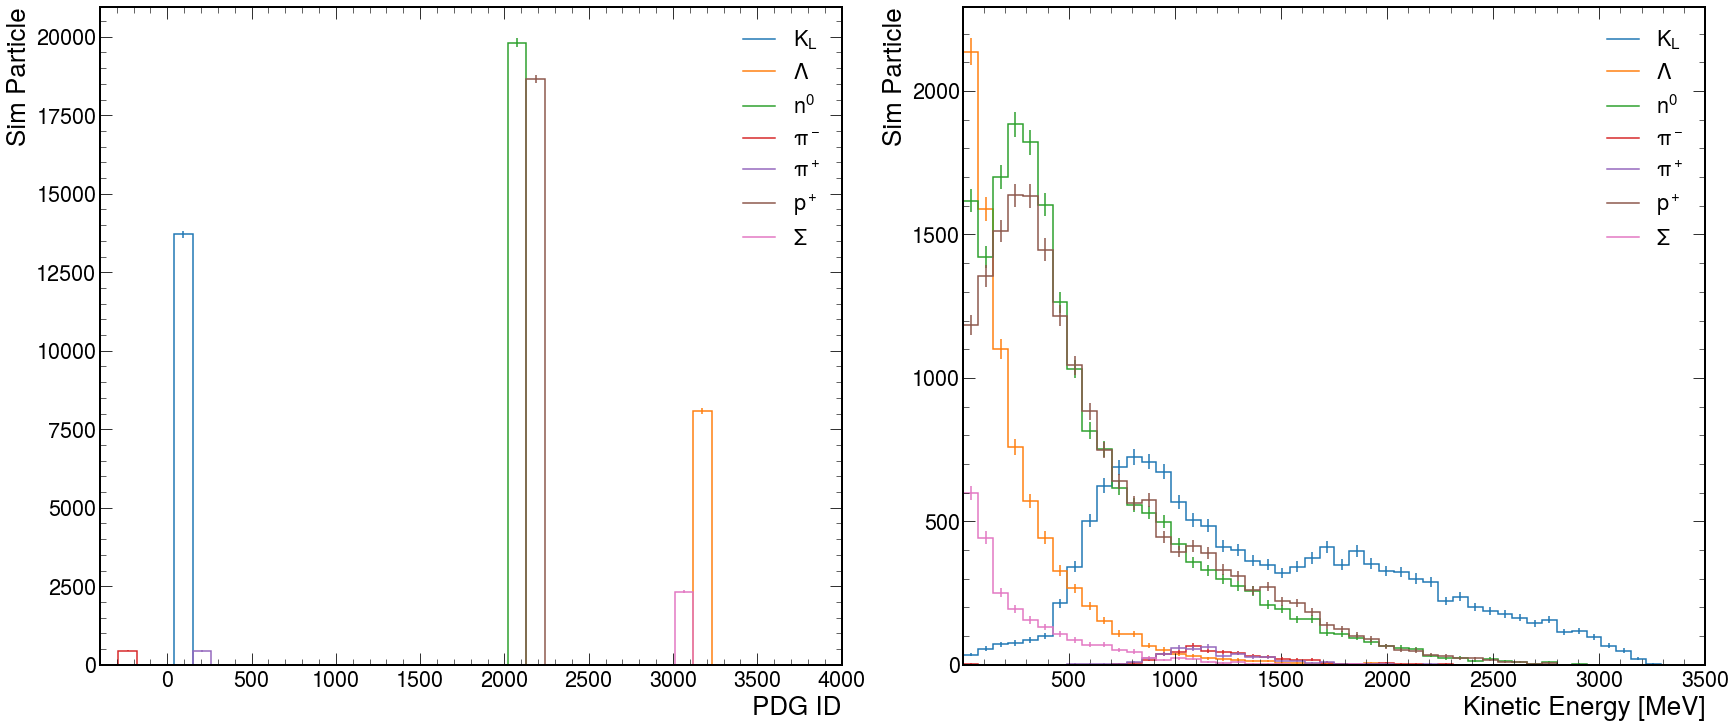

In [10]:
#48 kminus
print(hists["hist_pdgid1"])
fig, ax = plt.subplots(1,2, figsize=(24,10), constrained_layout=True)
hist.plot1d(hists["hist_pdgid1"]+hists["hist_pdgid2"],ax=ax[0],clear=False);
leg = ax[0].legend([r'$K_L$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$', r'$\Sigma$'])

hist.plot1d(hists["hist_ke1"]+hists["hist_ke2"],ax=ax[1],clear=False);
leg = ax[1].legend([r'$K_L$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$', r'$\Sigma$'])

